In [18]:
import sys
sys.path.append(r'\\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources')
from IPython.display import display
import random
from random import seed
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
import spacy
nlp = spacy.load('en')

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import defaultdict,Counter
from itertools import zip_longest
from IPython.display import display
get_ipython().magic('matplotlib inline')
import random
import math
import matplotlib.pylab as pylab
%matplotlib inline
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from pylab import rcParams
from operator import itemgetter, attrgetter, methodcaller
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import csv
from classification_utils import * 

dvd_reviews = [review for review in AmazonReviewCorpusReader().category("dvd").raw()]

# Section 1: Document Level Sentiment Analysis

## Section 1.1

A Naive-Bayes Classifier has better performance than a wordlist classifier for determining the sentiment of a document.

Both classifiers use labelled data to learn but the difference is in the way they perform the analysis of an unseen document.

The wordlist classifier makes a basic count of whether each word is in a positive or negative list of words. Based on whether the count is positive or negative, it determines the sentiment. Accuracy is not always right because it chooses randomly if count is zero. Moreover, sometimes a sentence might have more words from the negative list, but the overall opinion might still be positive.

The Naive-Bayes Classifier has a different approach. It uses probability to classify a document. It uses Bayes' rule, class priors and conditional probabilities to make the necessary calculations. It also uses a known vocabulary which can be always expanded. It performs better because there is more sophisticated maths in the way it's built.

In [6]:
dvd_reader = AmazonReviewCorpusReader().category("dvd")
word_list_size = 100
repetitions = 5 # accuracy figures are averaged over this many repetitions
WL_accuracy_tot = 0
NB_accuracy_tot = 0
for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions
    pos_train,neg_train,pos_test,neg_test = get_train_test_data(dvd_reader)
    WL_accuracy_tot += run_WL(pos_train,neg_train,pos_test,neg_test,word_list_size)
    NB_accuracy_tot += run_NB(pos_train,neg_train,pos_test,neg_test)
WL_accuracy = WL_accuracy_tot/repetitions
NB_accuracy = NB_accuracy_tot/repetitions
df = pd.DataFrame([("Word List",WL_accuracy),("NB",NB_accuracy)])
display(df)

,0,1
0,Word List,0.631333
1,NB,0.789000


## Section 1.2

The dataframe below shows how the Naive-Bayes Classifier improves when we increase the amount of data. We can see that its performance becomes better overall, which is logical since increasing the data, we increase the training data, or the known vocabulary, so it has a better chance to make correct analysis. However, in some cases it stays the same or even becomes worse. There is a big difference in its performance on a sample of one document compared to a sample of 100, but not that much from 400 to 700 for instance. Following from there, I think that if we increase the data massively, its performance wouldn't go much beyond 0.85 - 0.90.


In [7]:
reader = AmazonReviewCorpusReader().category("kitchen")
word_list_size = 100
repetitions = 1 # accuracy figures are averaged over this many repetitions
sample_sizes = [1,10,50,100,200,400,600,700] #sample_size = number of the positive reviews =  number of negative reviews
WL_accuracies=[]
NB_accuracies=[]
for size in sample_sizes:
    WL_accuracy_tot = 0
    NB_accuracy_tot = 0
    for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions
        pos_train,neg_train,pos_test,neg_test = get_train_test_data(reader)
        pos_train_sample = sample(pos_train, size) 
        neg_train_sample = sample(neg_train, size) 
        WL_accuracy_tot += run_WL(pos_train_sample,neg_train_sample,pos_test,neg_test,word_list_size)
        NB_accuracy_tot += run_NB(pos_train_sample,neg_train_sample,pos_test,neg_test)
    WL_accuracies.append(WL_accuracy_tot/repetitions)
    NB_accuracies.append(NB_accuracy_tot/repetitions)

pd.set_option('precision',2)
df = pd.DataFrame(list(zip(sample_sizes, WL_accuracies, NB_accuracies)),
                  columns=["Sample size","WL accuracy","NB accuracy"])    
display(df)

,Sample size,WL accuracy,NB accuracy
0,1,0.53,0.54
1,10,0.53,0.55
2,50,0.62,0.68
3,100,0.62,0.71
4,200,0.66,0.77
5,400,0.65,0.80
6,600,0.69,0.81
7,700,0.68,0.85


## Section 1.3

Investigation of the impact on classifier accuracy of training a classifier with data in one domain (the source domain), and testing the same classifier on data from a different domain (the target domain) shows that some domain pairs lead to better accuracy than others. This might be caused by the different levels of similarity that domains have. The book and DVD domains have more in common in terms of vocabulary than book and electronics for instance. The Naive-Bayes Classifier creates a known vocabulary out of training data and then taking words from the testing data, it ignores these that are not present in its vocabulary. This means that it would ignore more words if the testing domain is a lot different and this will lead to worse accuracy overall. If the domains are similar, chances are they have more words in common, which means the classifier will make more use of its training. Of course, its accuracy will always be the best if using the same domains.

In [12]:
categories_pairs = [("book", "book"), ("book", "dvd"), ("book", "electronics"), ("book",  "kitchen"),
                    ("dvd", "dvd"), ("dvd", "book"), ("dvd", "electronics"), ("dvd", "kitchen"),
                    ("electronics", "electronics"), ("electronics", "book"), ("electronics", "dvd"), ("electronics", "kitchen"),
                    ("kitchen", "kitchen"), ("kitchen", "book"), ("kitchen", "dvd"), ("kitchen", "electronics")]
pair_accuracies = []
for cat in categories_pairs:
    repetitions = 3
    pair_accuracy_tot = 0
    for i in range(repetitions):
        source_test, source_train = get_formatted_train_test_data(cat[0])
        target_test, target_train = get_formatted_train_test_data(cat[1])
        pair_accuracy_tot += run_NB_preformatted(source_train, target_test)
    pair_accuracies.append(pair_accuracy_tot/repetitions)
df = pd.DataFrame(list(zip([cat[0] for cat in categories_pairs], [cat[1] for cat in categories_pairs], pair_accuracies)),
                 columns = ["Source Category", "Target Category", "Accuracy"])
display(df)

,Source Category,Target Category,Accuracy
0,book,book,0.92
1,book,dvd,0.73
2,book,electronics,0.64
3,book,kitchen,0.65
4,dvd,dvd,0.92
5,dvd,book,0.74
6,dvd,electronics,0.64
7,dvd,kitchen,0.67
8,electronics,electronics,0.92
9,electronics,book,0.69


## Section 1.4

By using different feature extraction methods we can see how the accuracy of the classifier changes. It's highest when we use all of the tokens in book and kitchen domain. In dvd the classifier is performing the best when we've filtered out non-alphabetic words and stopwords. In electronics its accuracy is highest when we've converted all tokens to lowercase. It's quite surprising that filtering numbers and stopwords does not lead to highest accuracy in all of the domains. It's even lowest in book and electronics. Converting tokens to NUM does not make much difference in most of the domains except in electronics. This might follow from the fact that in these revies there are a lot of numbers present (defining models and characteristics of different products for example) that make analysis more difficult.

,cat,all,lower,NUM,puncstop,stem
0,book,0.76,0.77,0.77,0.78,0.79
1,dvd,0.79,0.81,0.79,0.81,0.78
2,kitchen,0.84,0.81,0.82,0.81,0.82
3,electronics,0.80,0.80,0.80,0.80,0.80


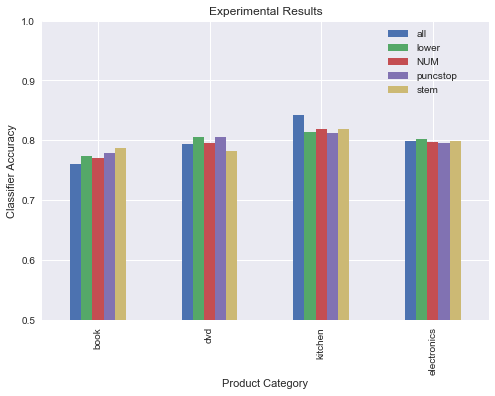

In [16]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def FE_all(review):
    return review.words()

def FE_lower(review):
    return [word.lower() for word in review.words()]

def FE_NUM(review):
    return ["NUM" if word.isdigit() else word for word in review.words()]

def FE_puncstop(review):
    return [word for word in review.words() if word.isalpha() and word not in stopwords]

def FE_stem(review):
    return [stemmer.stem(word) for word in review.words()]

def get_results(feature_extractor):
    results = {}
    for prod_cat in prod_cats:
        repetitions = 3 
        NB_accuracy_tot = 0
        for i in range(repetitions): 
            test, train   = get_formatted_train_test_data(prod_cat,feature_extractor)
            NB_accuracy_tot += run_NB_preformatted(train,test)
        results[prod_cat] = NB_accuracy_tot/repetitions
    return results

prod_cats = ["book","dvd","kitchen","electronics"]
FE_all_results = get_results(FE_all)
FE_lower_results = get_results(FE_lower)
FE_NUM_results = get_results(FE_NUM)
FE_puncstop_results = get_results(FE_puncstop)
FE_stem_results = get_results(FE_stem)

headers = ["cat","all","lower", "NUM", "puncstop", "stem"]

pd.set_option('precision',2)

df = pd.DataFrame(list(zip(prod_cats,
                           [FE_all_results[prod_cat] for prod_cat in prod_cats],
                           [FE_lower_results[prod_cat] for prod_cat in prod_cats],
                           [FE_NUM_results[prod_cat] for prod_cat in prod_cats],
                           [FE_puncstop_results[prod_cat] for prod_cat in prod_cats],
                           [FE_stem_results[prod_cat] for prod_cat in prod_cats])),
                  columns=headers)
display(df)
ax = df.plot.bar(x=0,title="Experimental Results")
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Product Category")
ax.set_ylim(0.5,1.0)
ax.legend(bbox_to_anchor=(0.95, 1))

# Section 2: Opinion Extractor

## Section 2.1


In my opinion_extractor I have a main method that deals with all extensions but conjunction which is separated as a separate 'conj_method'.

The global variables created in the two methods are counters for the number of sentences where each extension applied. They are for reporting later in Section 3.2 but I found it convenient to put them in the methods here.

'opinion_extractor' takes two arguments: aspect_token and parsed_sentence. It creates an empty list 'opinions' that keeps track of our opinion bearing words. A boolean 'neg' will mark the sentence as negative or not.

The method consists of two big for-loops that deal with two cases: we either have an aspect word with adjectives to it, or we have a form of 'to be' to which an adjective describing the aspect word is linked.

The first for-loop deals with the first case. It searches through all the children of the aspect word. It creates a new list 'phrases' to keep track of possible adverb+adjective phrases and negations.

If child is negative, it marks the sentence as negative by making the 'neg' boolean true.

If child has a dependency 'amod' and is an adjective, then it's the opinion bearing word we need. We add it to 'phrases'. Then we search through its children to find conjunctions or adverbs.

We use the 'conj_method' to search for conjunctions and then add them to our 'opinions' list. An explanation of it will follow below.

If we find a token with the dependency 'advmod', we've found our adverb. We make sure that if there is another adverb in our 'phrases', we put the new one in-between. I will take as an example the sentence "The plot for the movie is actually surprisingly straightforward once you cut away all the filler, but that's the biggest problem." If we don't have the if-statement explained above, the output will be 'surprisingly-actually-straightforward' which doesn't sound right. Normally the first adverb we find during the iteration is explanatory for the second one, so it needs to be at the front.

If we've marked our sentence as negative, we add 'not' to each adjective in 'phrases' and we append it to 'opinions'. If it's positive, we have two possibilities. First case, 'phrases' has more than one element which means it has an adverb and an adjective: we join the words with hyphens and then add them to 'opinions'. Second case, 'phrases' has only one item in it - an adjective: we simply add it to our 'opinions' list. The if-statement before appending makes sure the word added is an adjective and not a determinant (it's not an opinion bearing word, is it's a 'the').

The second for-loop deals with the case where we have a form of 'to be'. We search through all of the children of the verb. We create a new 'phrases' list to keep track of words we add. If we find a word with the dependency 'acomp', we've found an adjective or our opinion-bearing word. We add it to 'phrases'. Then we go into another for-loop to search through that token's children to cover conjunctions, adverbs and negations. We deal with conjunctions in the separate method. If we find an adverb, we check for the length of 'phrases': if it has only one item in it, we add it at the front of the list. If it has two, it means we have a 'not', so we make sure we add the adverb in-between. If we find a negation, we add 'not' at the front of the list. At the end we check for length of 'phrases' again to make sure we add hyphens if we have more than one word. Otherwise, we simply add the adjective to 'opinions'.

The 'conj_method' mirrors the 'opinion_extractor' method. It takes one argument: the token we need to check. It has two lists to keep track of everything we add and a boolean for negation. If the token has a dependency 'conj', we add it to 'conj' list. Then we search through its children. If we find another 'conj' dependency, we add it to the list. If we find an adverb, we make sure we add it at the front. If we find a 'neg' dependency, we mark the sentence as negative. If we have a non-empty list and 'conj_neg' is true, we add a 'not' in the list, concatenate everything with hyphens and add it to the main list. If 'conj_neg' is false, we simply add 'conj' to the main list. At the end we return the main list that's to be later appended to the 'opinions' list in 'opinion_extractor'.






In [19]:
#method for conjunction
def conj_method(child_of_adjective):
    global conj_ext_num #counter for use of extension E
    ops = []
    conj = []
    conj_neg = False
    if child_of_adjective.dep_ == 'conj':
        conj_ext_num += 1
        conj.append(child_of_adjective.orth_)
        for child_of_conj in child_of_adjective.children:
            if child_of_conj.dep_ == 'conj': #we search for more conjunctions
                conj.append(child_of_conj.orth_)
            if child_of_conj.dep_ == 'advmod':
                conj.insert(0, child_of_conj.orth_) #we make sure we insert the adverb in front of the adjective
            if child_of_conj.dep_ == 'neg':
                conj_neg = True #mark conjunction as negative
        if conj and conj_neg: #if we have negative conjunctions, make a joined negative string
            conj.insert(0, "not")
            joined_string = "-".join(conj)
            ops.append(joined_string)
        elif conj:
            ops.extend(conj)
    return ops

def opinion_extractor(aspect_token,parsed_sentence):
    global amod_ext_num #counter for use of extension A
    global acomp_ext_num #counter for use of extension B
    global advmod_ext_num #counter for use of extension C
    global neg_ext_num #counter for use of extension D
    opinions = []
    neg = False
    for token in parsed_sentence:
        if token.pos_ == 'NOUN' and token.orth_ == aspect_token:
            for child in token.children: #case 1: search for adjectives for aspect_token
                phrases = []
                if child.dep_ == 'neg':
                    neg = True
                if child.dep_ == 'amod' and child.pos_ == 'ADJ': 
                    amod_ext_num += 1
                    phrases.append(child.orth_)
                    for child_of_adjective in child.children:
                        opinions.extend(conj_method(child_of_adjective)) #check for conjunctions
                        if child_of_adjective.dep_ == 'advmod':
                            advmod_ext_num += 1
                            #check for length so as to check if there is more than one adverb in phrases: if yes, 
                            #need to insert the adverb between the two words.
                            if len(phrases) == 1:
                                phrases.insert(0, child_of_adjective.orth_)
                            else:
                                phrases.insert(1, child_of_adjective.orth_)   
                if neg:
                    neg_ext_num += 1
                    #if we have a negation, add 'not' for each adjective in phrases and add in opinions
                    for i in range(0, len(phrases)):
                        opinions.append("-".join(["not", phrases[i]]))
                else:
                    #if we have more than one word in phrases, this means we have an adverb, so add '-' between words
                    #before adding the phrase to opinions
                    if len(phrases) > 1:
                        joined_string = "-".join(phrases)
                        opinions.append(joined_string)
                    #else, just add the adjective in opinions
                    else:
                        if child.pos_ == 'ADJ': #we make sure we don't add determinants
                            opinions.append(child.orth_)   
            for child_of_head in token.head.children: #case 2: search through children of the head(form of to be)
                phrases = []
                adj_neg = False
                if child_of_head.dep_ == 'acomp':
                    acomp_ext_num += 1
                    phrases.append(child_of_head.orth_)                    
                    for child_of_adjective in child_of_head.children:
                        opinions.extend(conj_method(child_of_adjective))
                        if child_of_adjective.dep_ == 'advmod':
                            advmod_ext_num += 1
                            if len(phrases) == 1:
                                phrases.insert(0, child_of_adjective.orth_)
                            else:
                                phrases.insert(1, child_of_adjective.orth_)
                        if child_of_adjective.dep_ == 'neg':
                            neg_ext_num += 1
                            phrases.insert(0, "not")
                    if len(phrases) > 1:    
                        joined_string = "-".join(phrases)
                        opinions.insert(0, joined_string)
                    else:
                        opinions.insert(0, child_of_head.orth_)
    return opinions


## Section 2.2

In [29]:
ext_num = 0
amod_ext_num = 0
acomp_ext_num = 0
advmod_ext_num = 0
neg_ext_num = 0
conj_ext_num = 0

core_sentences = [("It has an exciting fresh plot.", ["exciting", "fresh"]), 
        ("The plot was dull.", "dull"),
        ("It has an excessively dull plot.", "excessively-dull"),
        ("The plot was excessively dull.", "excessively-dull"),
        ("The plot wasn't dull.", "not-dull"),
        ("It wasn't an exciting fresh plot.", ["not-exciting", "not-fresh"]),
        ("The plot wasn't excessively dull.", "not-excessively-dull"),
        ("The plot was cheesy, but fun and inspiring.", ["cheesy", "fun", "inspiring"]),
        ("The plot was really cheesy and not particularly special.", ["really-cheesy", "not-particularly-special"])]

def show_results(results,aspect_word):
    print("Results for aspect word '{}'\n".format(aspect_word))
    for word,sent,opinions,answer in results:
        if word == aspect_word:
            print("Sentence:\n\t{}".format(sent))
            print("The opinion should be:\n\t {0}".format(answer))
            print("Opinion of '{0}':\n\t '{1}'".format(aspect_word,"', '".join(opinions)))
            print("\n")
                
aspect_words = ["plot","characters","cinematography","dialogue"]

results = [] 
for review, answer in core_sentences:
    parsed_review = nlp(review)
    for sentence in parsed_review.sents:
        for aspect_token in aspect_words:
            opinions = opinion_extractor(aspect_token,sentence)
            if opinions:
                results.append((aspect_token,sentence.orth_,opinions, answer))

show_results(results,"plot")

Results for aspect word 'plot'

Sentence:
	It has an exciting fresh plot.
The opinion should be:
	 ['exciting', 'fresh']
Opinion of 'plot':
	 'exciting', 'fresh'


Sentence:
	The plot was dull.
The opinion should be:
	 dull
Opinion of 'plot':
	 'dull'


Sentence:
	It has an excessively dull plot.
The opinion should be:
	 excessively-dull
Opinion of 'plot':
	 'excessively-dull'


Sentence:
	The plot was excessively dull.
The opinion should be:
	 excessively-dull
Opinion of 'plot':
	 'excessively-dull'


Sentence:
	The plot wasn't dull.
The opinion should be:
	 not-dull
Opinion of 'plot':
	 'not-dull'


Sentence:
	It wasn't an exciting fresh plot.
The opinion should be:
	 ['not-exciting', 'not-fresh']
Opinion of 'plot':
	 'not-exciting', 'not-fresh'


Sentence:
	The plot wasn't excessively dull.
The opinion should be:
	 not-excessively-dull
Opinion of 'plot':
	 'not-excessively-dull'


Sentence:
	The plot was cheesy, but fun and inspiring.
The opinion should be:
	 ['cheesy', 'fun', 'insp

A little side note: I have over-complicated my method by making it return opinion words in the same order in the core set. That's why here I haven't created a set for them, but just a list.

# Section 3: Assessment of Opinion Extractor Performance

## Section 3.1

In [6]:
seed(167184)

def target_sentence(sentence,target_tokens):
    for token in sentence:
        if token.orth_ in target_tokens:
            return True
    return False

target_tokens = {"plot","characters","cinematography","dialogue"}
sample_size = 100
my_sample = []
num_found = 0
while num_found < sample_size:
    review = random.choice(dvd_reviews)
    parsed_review = nlp(review)
    sentence = random.choice(list(parsed_review.sents))
    if target_sentence(sentence,target_tokens):
        my_sample.append(sentence)
        num_found += 1

In [7]:

def number_of_aspect_words(sample):
    num_plot = 0
    num_characters = 0
    num_cinematography = 0
    num_dialogue = 0
    for sentence in sample:
        for token in sentence:
            if token.orth_ == "plot":
                num_plot +=1
            if token.orth_ == "characters":
                num_characters += 1
            if token.orth_ == "cinematography":
                num_cinematography += 1
            if token.orth_ == "dialogue":
                num_dialogue += 1  
    nums = [num_plot, num_characters, num_cinematography, num_dialogue]
    for aspect_word, number in zip(aspect_words, nums):
        print("Number of sentences with '{0}': {1}".format(aspect_word, number))
    
    
number_of_aspect_words(my_sample)

Number of sentences with 'plot': 37
Number of sentences with 'characters': 48
Number of sentences with 'cinematography': 1
Number of sentences with 'dialogue': 18


As you will see after executing the cell above, sentences with 'plot' are 37, with 'characters' - 48, with 'cinematography' - 1, and with 'dialogue' - 18. The sum of all of them is 104 and not 100, because two of the sentences include both 'plot' and 'characters' which means they are each counted twice.

## Section 3.2

In [8]:
ext_num = 0
amod_ext_num = 0
acomp_ext_num = 0
advmod_ext_num = 0
neg_ext_num = 0
conj_ext_num = 0

results = [] 
for sentence in my_sample:
    for aspect_token in aspect_words:
        opinions = opinion_extractor(aspect_token,sentence)
        if opinions:
            ext_num += 1
            results.append((aspect_token,sentence.orth_,opinions))

show_results(results,"plot")
show_results(results,"characters")
show_results(results,"cinematography")
show_results(results,"dialogue")


Results for aspect word 'plot'

Sentence:
	The similarities of these 2 movies are so prominent that it would actually be a waste of time and money to buy both - same characters, same plot only in a different setting.
Opinion of 'plot':
	 'same'


Sentence:
	As far as the movie is concerned, the plot is unoriginal and not particularly engaging.
Opinion of 'plot':
	 'unoriginal', 'not-particularly-engaging'


Sentence:
	it was an ight movie..had lots of action, pretty gory compared to other Jet li movies.. the movie has a cheesy plot..but the action covers it all.. the fighting in the movie cant be compared to that of Fist of legend (wich in my oponion is Jet Li's best work) but its still adds up to great action..one things for shure, this aint really a hard core martial arts movie..theres is alot of shootings..stabbings, killing..gory scenes and sum distrubing scenes..pretty dark for a jet li movie..thats why i kina understand the "R" rating.. the swearing is really fun too..because the

In [13]:
extensions = [("Extension A: Adjectival modification"), ("Extension B: Adjectives linked by copulae"), 
             ("Extension C: Adverbial modifiers"), ("Extension D: Negation"), ("Extension E: Conjunction")]
ext_nums = [amod_ext_num, acomp_ext_num, advmod_ext_num, neg_ext_num, conj_ext_num]
print("Number of sentences where opinion extractor worked: {0} \n".format(ext_num))
for ext, num in zip(extensions, ext_nums):
    print("Number of sentences where '{0}' was applied: {1}\n".format(ext, num))

Number of sentences where opinion extractor worked: 45 

Number of sentences where 'Extension A: Adjectival modification' was applied: 36

Number of sentences where 'Extension B: Adjectives linked by copulae' was applied: 9

Number of sentences where 'Extension C: Adverbial modifiers' was applied: 8

Number of sentences where 'Extension D: Negation' was applied: 0

Number of sentences where 'Extension E: Conjunction' was applied: 4



#### Running the cell above will give indication of how many times each extension was applied.

- Examples that include extension A are:

"This film has it all, great performances, great direction, and great cinematography."

    Opinion of 'cinematography': 'great'
    
`Good plot.`

    Opinion of 'plot':'Good'

- Examples that include extension B are:

"The singing is not bad (this cast has better technical control of their voices compared to the cast in Les Miz) but the choreography is trite and unimaginative, and the acting so juvenille that you'd think the characters are retarded."

    Opinion of 'characters': 'retarded'
    

    
- Examples that include extension C are:
    
"I enjoyed this movie because the plot was very different and not run of the mill like most horror movies."

    Opinion of 'plot': 'very-different'

"The dialogue is completely unbelievable considering the age of these kids."

    Opinion of 'dialogue': 'completely-unbelievable'
    
- Examples that include extension D are:

"As far as the movie is concerned, the plot is unoriginal and not particularly engaging."

    Opinion of 'plot': 'unoriginal', 'not-particularly-engaging'
    
- Examples that include extension E are:
    
"The plot is stupid, the characters are dull and insipid, and the whole movie leaves you asking, as the credits run, "So What?" Don't waste your money!"

    Opinion of 'characters': 'dull', 'insipid'
    
"The characters are very well developed and outlandish from the eccentricly outgoing berry(Jack Black) to the quiet weird geek type Dick."

    Opinion of 'characters': 'well-developed', 'outlandish'








#### The cell above also gives an overall number of how many of the sentences the opinion extractor worked for in the sense that it did not return an empty 'opinions' list. 
It is 45 out of 100 in the sample.

The number of sentences which the extractor analysed correctly is much smaller. After going through the results of each sentence, I went to the conclusion that the opinion extractor analysed correctly 42.22% of the sentences it worked for. After taking into consideration the sentences it did not produce any output for at all, the proportion becomes 19%.

#### Some of the sentences that were perfectly analysed are:




"As far as the movie is concerned, the plot is unoriginal and not particularly engaging."

    Opinion of 'plot': 'unoriginal', 'not-particularly-engaging'

"The plot is stupid, the characters are dull and insipid, and the whole movie leaves you asking, as the credits run, "So What?" Don't waste your money!"

    Opinion of 'characters': 'dull', 'insipid'

"It's for anyone who has a longing to "escape" the everyday just for awhile...just a fun story, charming characters, and a wonderful love story that makes you want to fly off to Rome"

    Opinion of 'characters':'charming'


"This is a must-have if you like a good story line, clever dialogue and honest laughs."

    Opinion of 'dialogue': 'clever'


"If you want to watch an amazing movie get this movie and watch it because you will never see anything like this ever again russel's performance is incredible and denzel performence is also incredble over all this movie is one helleva movie because they both play very complex characters and they do very good jobs you won't see the sadistic and actual enjoyment out of killing people that you see here anywhere else get this movie it is a keeper I personally like the sadistic demeanor and uncontrollable carnage in the movie have fun watching it"

    Opinion of 'characters': 'very-complex'

#### In many cases the opinion extractor did not work properly. These include:

"For a more explosive ride, with a more entertaining character, and a much simpler drug-induced and graphic plot, see the recently released Crank - excellent action/adventure from the Transporter man."

    Opinion of 'plot': 'much-simpler', 'graphic'

- In this case 'induced' here has a dependency 'amod', but its tag is verb, and in my opinion-extractor I'm only searching for adjectives.


"It was not the actual story/plot, or it's accuracy that was important to me."

    Opinion of 'plot': 'actual'

- The first mistake here: actual is not an opinion bearing word. This has happened in a couple of other sentences as well like: "The other characters (teenagers) are a "fag hag", a cross dresser, a chubby girl who has her mouth wired shut, a bleached blonde who thinks too highly of herself and her meek sidekick and a rare straight boy at the camp who lacks self-esteem." or "Also, all the characters knew of the dangerous gingerbread man in the bakery but they never left to get help, it was as easy as opening the door and leaving, but no...can't do that.". The algorithms detects words like 'their', 'all', 'its' which have tags adjectives.

- The second mistake is it has not detected 'not' which might be a flaw in the dependency parser.

"I think the director needs prozac to direct this movie, the whole plot is so mess up, junior high student can write better story than this..what was he thinking. don't waste your money buying this movi"

    Opinion of 'plot': 'whole'

- The algorithm should have detected "so mess up", so it might be a deficiency in the dependency parser as one of the previous examples.

"The similarities of these 2 movies are so prominent that it would actually be a waste of time and money to buy both - same characters, same plot only in a different setting."

    Opinion of 'characters': 'both - same'

- The algorithm should not have detected "both", although it's 'advmod' to "same".


"It's characters are re-created after Fellini's cartoons, or stereotypes (some based on real characters in Rimini), some comlpetely imaginary, all most funny and entertaining."

- In this case 'imaginary', 'funny' and 'entertaining' haven't been detected, because of a flaw in the dependency parser: imaginary is head of sentence after the brackets, so the algorithm can't see it.

"There is no humor, no likable characters, not even a decent quote or one liner.   by the time it ambles toward its pathetic excuse for a conclusion"

    Opinion of 'characters': 'likable'

- The algorithm is not searching for a determinant "no".

#### Another problem with negation is in this sentence:

"The big problem with RH is that neither Ford or Benning are sympathetic characters."

- The algorithm has only detected 'sympathetic' because it's not searching for 'preconj' which is 'neither'.

The opinion extractor does not search for adverbs or adjectives recursively which creates problems in cases where we have more than one/two of them:

"There are many good supporting characters such as: Bridget Fonda, Woody Harrelson, Barnard Hughes and Julie Warner"

    Opinion of 'characters': 'many', 'good'

- The algorithm has not detected the third 'amod'.

"The characters are very well developed and outlandish from the eccentricly outgoing berry(Jack Black) to the quiet weird geek type Dick."

    Opinion of 'characters': 'well-developed', 'outlandish'

- The algorithm has not found second adverb 'very'.

#### Another example I'll give is for cases where there is a whole phrase describing an aspect word, and the algorithm fails to detect it:

"Depth in its story, depth in its characters, and this is why people of all age groups (I myself am 22+) will love this show."

    Opinion of 'characters': 'its' (instead of 'depth in' for instance)
    
"I enjoyed this movie because the plot was very different and not run of the mill like most horror movies."

    Opinion of 'plot': 'very-different'

    
#### A big part of the failure of the opinion extractor on the sentences in the sample is the fact that the parser is not working as expected.

"Very good plot and detail"

    Opinion of 'plot': 'good'
    
- Here 'very' hasn't been detected because while it is supposed to be an advmod of very, it is actually another child of plot.

"It was not the actual story/plot, or it's accuracy that was important to me."

    Opinion of 'plot': 'actual'
    
- Here 'not' is supposed to be child of plot (we have been told of this discrepancy in spaCy) but it is parsed as child of 'was'.


#### As it can be seen from the counters of extensions, negation has not been counted at all and I'm assuming it is because of this particular descrepancy in the parser and the actual tree. Moreover, there weren't many sentences with classic negation in the sample.

    


## Section 3.3

After looking at the results, it becomes obvious that the 'opinion extractor' can be improved in several ways. Firstly, recursions can be added for each of the extensions. By doing that, we'll make sure it finds all of the opinion bearing words for each extension, and within the extensions as well. Secondly, restrictions regarding tags of words can be more specific. In the places of the algorithm where it is searching for 'amod's that are adjectives, it can be developed to search for adjectives and verbs as well (and any other part of speech that is suitable). Thirdly, searching for negation can be developped a lot more. It can search for words like 'neither', 'nor' and 'no' (that have different dependencies - investigation into this is required.) Also, the algorithm can be made to ignore words like 'their', 'all', 'its' by checking for them in a list with words to be ignored. That way, even if the words have the right dependencies and tags, they won't be taken into consideration.
Lastly, the algorithm can be complicated as to search for whole phrases that describe the aspect words. In many of the sentences with 'characters' we fail to establish the opinion of the author because it lies in the sentence as a whole, and not only in a couple of adjectives. By adding functionality, we'll get closer to the right opinion.